In [10]:
from donut import *
import random
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pylab import savefig
%matplotlib inline

#Donut stuff
random.seed()
randSeed = random.randint(0,1000000)

w = cruller.WordList()
w.LoadFromFile("/Users/Rylan/cisc/creamTeam/wordLists/WordList_20000_combined_check.dat")
w.SetSeed(randSeed)

k = bearclaw.MakeStandardKeyboard()
k.SetSeed(randSeed)
k.RemoveKey('.')
kStan = k

In [2]:
#Utility functions

def ElliotFunction(x):
    s=0.5
    return (0.5*s*x)/(1+s*abs(x)) + 0.5

def getLayer(i,nn_struct):
    cumSum, iter = nn_struct[0],0
    while(i >= cumSum):
        cumSum+=nn_struct[iter+1]
        iter+=1
    return iter

def cumList(nn_struct):
    clist = []
    cum = 0
    for n in nn_struct:
        cum+=n
        clist.append(cum)
    return clist

def scaleTo01(list):
    return [(value-min(list))/(max(list)-min(list)) for value in list]

def scaleTo11(list):
    return [(value-min(list))/(0.5*(max(list)-min(list)))-1 for value in list]

def scaleTo31(list):
    return [(value-min(list))/((10/7)*(max(list)-min(list)))+0.3 for value in list]

In [139]:
class node:
    def __init__(self,x,y,index):
        self.x = x
        self.y = y
        self.index = index
        self.inList = []
        self.activation = 0
        
    def setX(self,x):
        self.x = x
    def getX(self):
        return (self.x)
    
    def setY(self,y):
        self.y = y
    def getY(self):
        return (self.y)
    
    def setIndex(self, index):
        self.index = index
    def getIndex(self):
        return self.index
    
    def setAct(self,act):
        self.activation = ElliotFunction(act)
    def setInputAct(self,act):
        self.activation = act
    def setBias(self):
        self.activation = 1.0
    def getAct(self):
        return self.activation
    
    def addInput(self,connect):
        self.inList.append(connect)
    def getInputs(self):
        return self.inList
    
    
class connection:
    def __init__(self,startN,endN,weight,rad):
        self.startN = startN
        self.endN = endN
        self.weight = weight
        self.rad = rad
        self.x1 = startN.getX()
        self.x2 = endN.getX()
        self.y1 = startN.getY()
        self.y2 = endN.getY()
        
    def drawX1(self):
        return self.x1 + self.rad*math.cos(math.atan2(self.y2-self.y1,self.x2-self.x1))
    def drawY1(self):
        return self.y1 + self.rad*math.sin(math.atan2(self.y2-self.y1,self.x2-self.x1))
    def drawX2(self):
        return self.x2 - self.rad*math.cos(math.atan2(self.y2-self.y1,self.x2-self.x1))
    def drawY2(self):
        return self.y2 - self.rad*math.sin(math.atan2(self.y2-self.y1,self.x2-self.x1))
        
    def setWeight(self,weight):
        self.weight = weight
    def getWeight(self):
        return self.weight
    def getInputValue(self):
        return self.weight*self.startN.getAct()

In [239]:
#Accepts a list as input that containes the number of nodes in each layer
#starting with the input and ending with the output layer.  The bias unit
#must also be included 

def DrawNN(nn_struct,weight_list,input_list,save=False,filename="none"):
    if(len(input_list) != (nn_struct[0]-1)):
        print("\nTHE NUMBER OF INPUTS DOESN'T MATCH THE NUMBER OF INPUT NEURONS\n")
        return
    
    nLayers = len(nn_struct)
    #the partition of the node indices by layer
    lPart = cumList(nn_struct) 

    #plotting parameters
    xDim, yDim = 18,10
    plt.figure(figsize=(xDim,yDim))
    xDist = xDim/(nLayers-1)
    yDist = yDim/(max(nn_struct)+1)
    rad = yDist/4
    plt.axes()
    
    #create all of the nodes in the nn
    nodes = []
    i = 0
    for layer in range(len(nn_struct)):
        nNodes = nn_struct[layer]
        for n in range(nNodes):
            x = layer*xDist
            y = -(nNodes-1)*0.5*yDist + n*yDist
            newnode = node(x,y,i)
            if n == nNodes -1:
                newnode.setBias()
            nodes.append(newnode)
            i+=1
                
    #create all of the connections in the nn and calculate the nueron activations
    connects = []
    i = 0
    for nIter in nodes:
        layer = getLayer(nIter.index,nn_struct)
        if layer == nLayers-1:
            break
        #find the index of the nodes to connect the current node to
        nlStart = lPart[layer]
        nlEnd = lPart[layer] + nn_struct[layer+1] - 1 
        if layer == len(nn_struct)-2:
            nlEnd+=1
        #make connections
        for cIter in range(nlStart,nlEnd):
            conn = connection(nIter,nodes[cIter],weight_list[i],rad)
            connects.append(conn)
            nodes[cIter].addInput(conn)
            i+=1
        #set the activations for the input neurons
        if nIter.getIndex() < nn_struct[0]-2:
            nIter.setInputAct(input_list[nIter.getIndex()])
        else:
            #add up the weights and activations and set the activation value for the current node
            nIter.setAct(sum([cn.getInputValue() for cn in nIter.getInputs()]))

    #calculate output 
    nodes[-1].setAct(sum([cn.getInputValue() for cn in nodes[-1].getInputs()]))
    
           
    iv_list,clw_list,nfc_list  = [],[],[]
    #draw nodes    
    for nd in nodes:
        nfc = nd.getAct()
        nfc_list.append(nfc)
        if nfc > 1:
            print("nfc overflow = ",nfc)
            nfc = 1
        if nfc < 0:
            print("nfc overflow = ",nfc)
            nfc = 0
        circle = plt.Circle((nd.getX(),nd.getY()),radius=rad,fc=str(nfc),lw=2)
        plt.gca().add_patch(circle)
    
    #get weights and input values to scale
    for cn in connects:
        iv_list.append(cn.getInputValue())
    iv_scaled = scaleTo11(iv_list)
    
    #draw connections
    clw = [abs(w) for w in iv_scaled]
    for i in range(len(connects)):
        if w_list[i] < 0:
            color = 'blue'
        else: 
            color = 'red'
        color = 'black'
        plt.arrow(connects[i].drawX1(),connects[i].drawY1(),connects[i].drawX2()-connects[i].drawX1(),
                  connects[i].drawY2()-connects[i].drawY1(),length_includes_head=True,lw=1.5,color=color,
                  alpha=clw[i],aa=True,head_width=0.08,fc=color)

    print("ivl range:",min(iv_list),max(iv_list))
    print("output activation = ",nodes[-1].getAct())
    print("nnDist            = ", nnDist)
    
    plt.gca().set_xlim(-xDist/4,xDim+xDist/4)
    plt.gca().set_ylim(-yDim/2,yDim/2)
    if(save):
        savefig(filename)
    plt.show()

In [5]:
#Load the connections from the nn 
file= open("/Users/Rylan/cisc/creamTeam/FANN/connections.txt","r")
data = [(int(line.split()[0]),int(line.split()[1]),float(line.split()[2])) for line in file]
nnConnections = [d[2] for d in data]
print("nConnectsions = ",len(nnConnections))
#[print(d) for d in data]
print("weight range:",min(nnConnections),max(nnConnections))

nConnectsions =  423
weight range: -171.383667 193.864227


Distance =  0.07510322332382202
[0.08500777930021286, 6.766119480133057, 2.322313070297241, 0.26718342304229736, 0.2661569118499756, 0.23466645181179047, 0.32217511534690857, 0.1768188178539276, 0.014456495642662048, 0.04146791994571686, 0.20930014550685883]


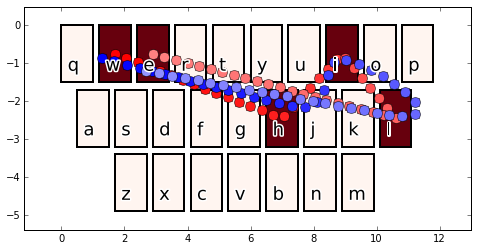

In [245]:
#Get the inputs for a specific swipe example
ivL = 50
modelNN = cruller.NeuralNetworkModel("/Users/Rylan/cisc/creamTeam/FANN/trainedNets/fann_donutSwypeDistance_HLIv4_elliotDeepArch_ElliotOut_randWeights_2kIt_ivL25_5randInterps.net")
model = cruller.SimpleInterpolationModel()
model.SetSeed(random.randint(0,1000000))
model.SetXScale(0.75)
model.SetYScale(0.5)
model.SetCorrelation(0)
model.SetVectorLength(ivL)
model.Interpolation = cruller.ModCubicSplineInterpolation

modelP = cruller.SimpleInterpolationModel()
modelP.SetVectorLength(ivL)

word1 = "while"
word2 = "while"
while(True):
    iv1 = model.RandomVector(word1,kStan)
    #iv2 = model.RandomVector(word2,kStan)
    iv2 = modelP.PerfectVector(word2,kStan)
    fset = cruller.CreateNeuralNetworkInputs(iv1,iv2)
    nnDist = modelNN.VectorDistance(iv1,iv2)
    if(0.<nnDist<0.08):
#    if(0.98<nnDist<1):
#    if(0.5<nnDist<0.6):
        break
print("Distance = ",nnDist)
print(fset)
bearclaw.DrawKeyboard(kStan,inputvector=[iv2,iv1],frequencymap=word1,colormap=mpl.cm.Reds,figsize=(8,4),nopalette=True)

nfc overflow =  21.474214553833008
nfc overflow =  17.01382827758789
nfc overflow =  1.007933497428894
nfc overflow =  1.4868580102920532
ivl range: -32.23742789865278 44.856533196363685
output activation =  0.07696837961305364
nnDist            =  0.9884425103664398


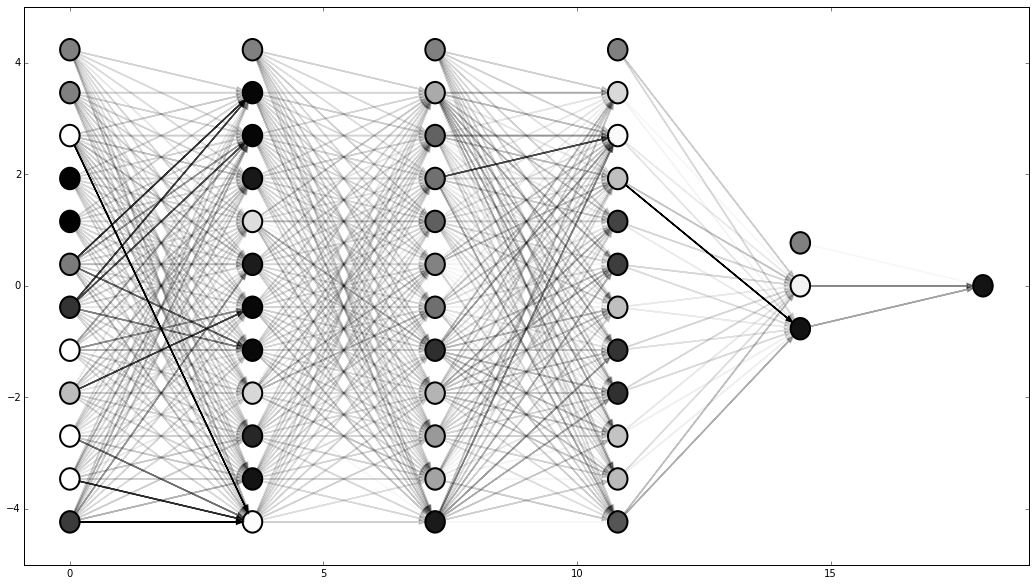

In [244]:
nn_str = [12,12,12,12,3,1]
inputs = fset

DrawNN(nn_str,nnConnections,inputs,save=False,filename="/Users/Rylan/cisc/creamTeam/DonutDocs/plots/nn_nonmatch_2.pdf")

nfc overflow =  6.766119480133057
nfc overflow =  2.322313070297241
ivl range: -40.0179191782772 19.164878880627015
output activation =  0.7654324348241018
nnDist            =  0.07510322332382202


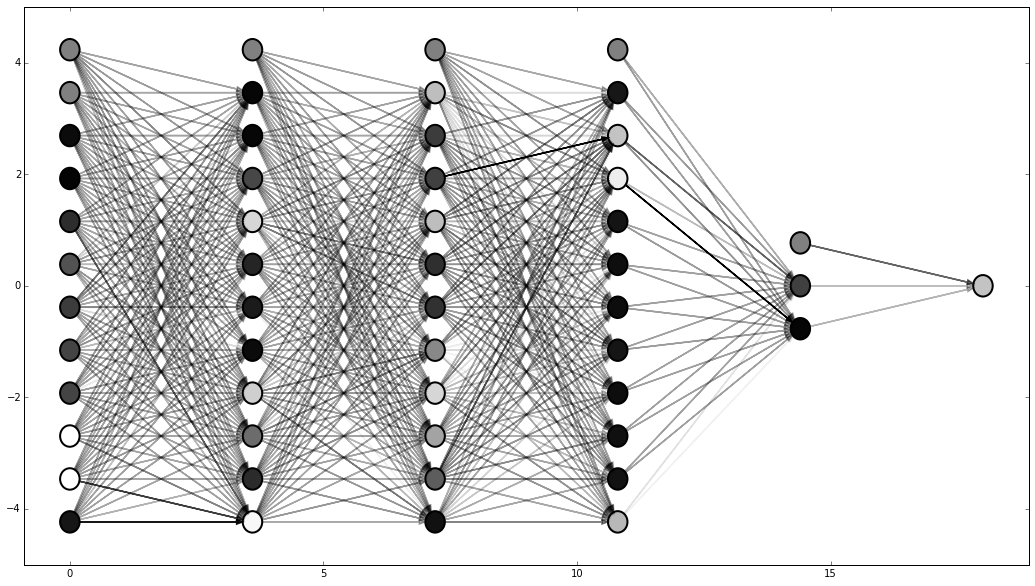

In [248]:
nn_str = [12,12,12,12,3,1]
inputs = fset

DrawNN(nn_str,nnConnections,inputs,save=True,filename="/Users/Rylan/cisc/creamTeam/DonutDocs/plots/nn_match_1.pdf")

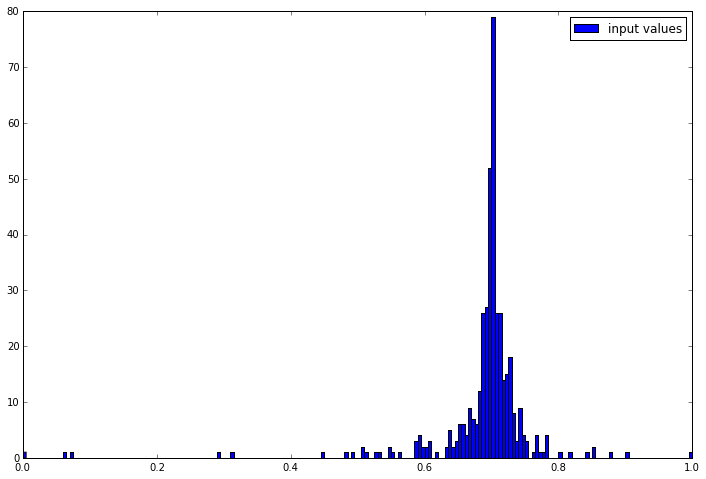

In [238]:
list1 = iv_list
#list1 = scaleTo11(list1)
list11 = [(math.erf(10*w-4)+1)/2 for w in list1]
list1 = scaleTo01(list1)

plt.figure(figsize=(12,8))
n1, b, p = plt.hist(list1,200,label="input values",normed=False,alpha=1.0)
#n11, b, p = plt.hist(list11,200,label="scaled iv",normed=False,alpha=0.6)
plt.legend()
plt.gca().set_xlim(min(list1),max(list1))
plt.show()